# Face Search: One-to-Many Face Matching

This notebook demonstrates how to build a face database and search for matching faces - useful for photo organization, security systems, and social media applications.

In [ ]:
%pip install -q uniface

# Clone repo for assets (Colab only)
import os
if 'COLAB_GPU' in os.environ or 'COLAB_RELEASE_TAG' in os.environ:
    if not os.path.exists('uniface'):
        !git clone --depth 1 https://github.com/yakhyo/uniface.git
    os.chdir('uniface/examples')

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import cv2
import matplotlib.pyplot as plt

import uniface
from uniface import FaceAnalyzer
from uniface.detection import RetinaFace
from uniface.recognition import ArcFace

print(uniface.__version__)

2.0.0


In [3]:
analyzer = FaceAnalyzer(
    detector=RetinaFace(confidence_threshold=0.5),
    recognizer=ArcFace()
)

✓ Model loaded (CoreML (Apple Silicon))
✓ Model loaded (CoreML (Apple Silicon))


In [4]:
# Load Einstein's photo
einstein_path = '../assets/einstien.png'
einstein_image = cv2.imread(einstein_path)

# Get Einstein's face features
einstein_faces = analyzer.analyze(einstein_image)

if einstein_faces:
    einstein_face = einstein_faces[0]
    print(f'Detected {len(einstein_faces)} face with {einstein_face.embedding.shape[1]}D features')


Detected 1 face with 512D features


In [5]:
# Load the group photo
group_photo_path = '../assets/scientists.png'
group_photo = cv2.imread(group_photo_path)

# Find all faces in the group photo
group_faces = analyzer.analyze(group_photo)
print(f'Detected {len(group_faces)} people in the group photo')

Detected 29 people in the group photo


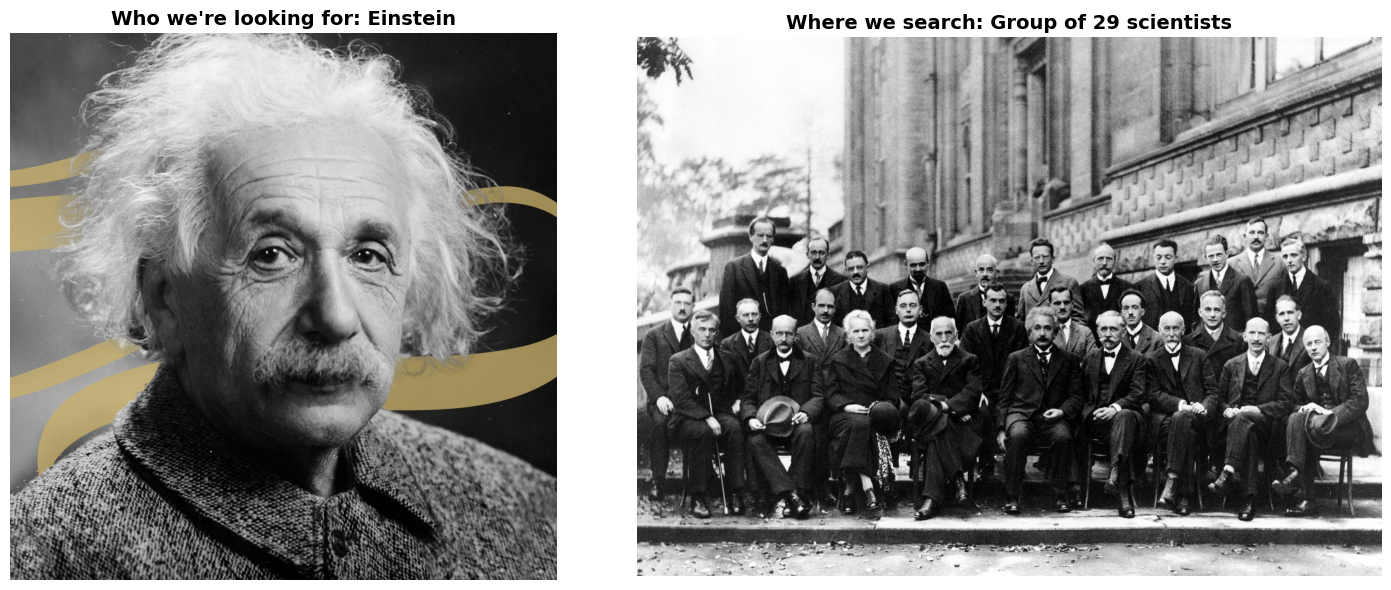

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Display Einstein's photo
axes[0].imshow(cv2.cvtColor(einstein_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("Who we're looking for: Einstein", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Display the group photo
axes[1].imshow(cv2.cvtColor(group_photo, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Where we search: Group of {len(group_faces)} scientists', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
if not einstein_faces or not group_faces:
    print('Error: Could not detect faces')
else:
    # Compare Einstein with each person in the group
    matches = []
    for i, person in enumerate(group_faces):
        similarity = einstein_face.compute_similarity(person)
        matches.append((i, similarity))

    # Sort by similarity (best matches first)
    matches.sort(key=lambda x: x[1], reverse=True)

    # Show top 5 matches
    print('Top 5 most similar people:')
    for rank, (person_idx, similarity) in enumerate(matches[:5], 1):
        print(f'{rank}. Person #{person_idx + 1}: similarity = {similarity:.4f}')


Top 5 most similar people:
1. Person #11: similarity = 0.6171
2. Person #15: similarity = 0.1934
3. Person #17: similarity = 0.1844
4. Person #25: similarity = 0.1556
5. Person #19: similarity = 0.1550


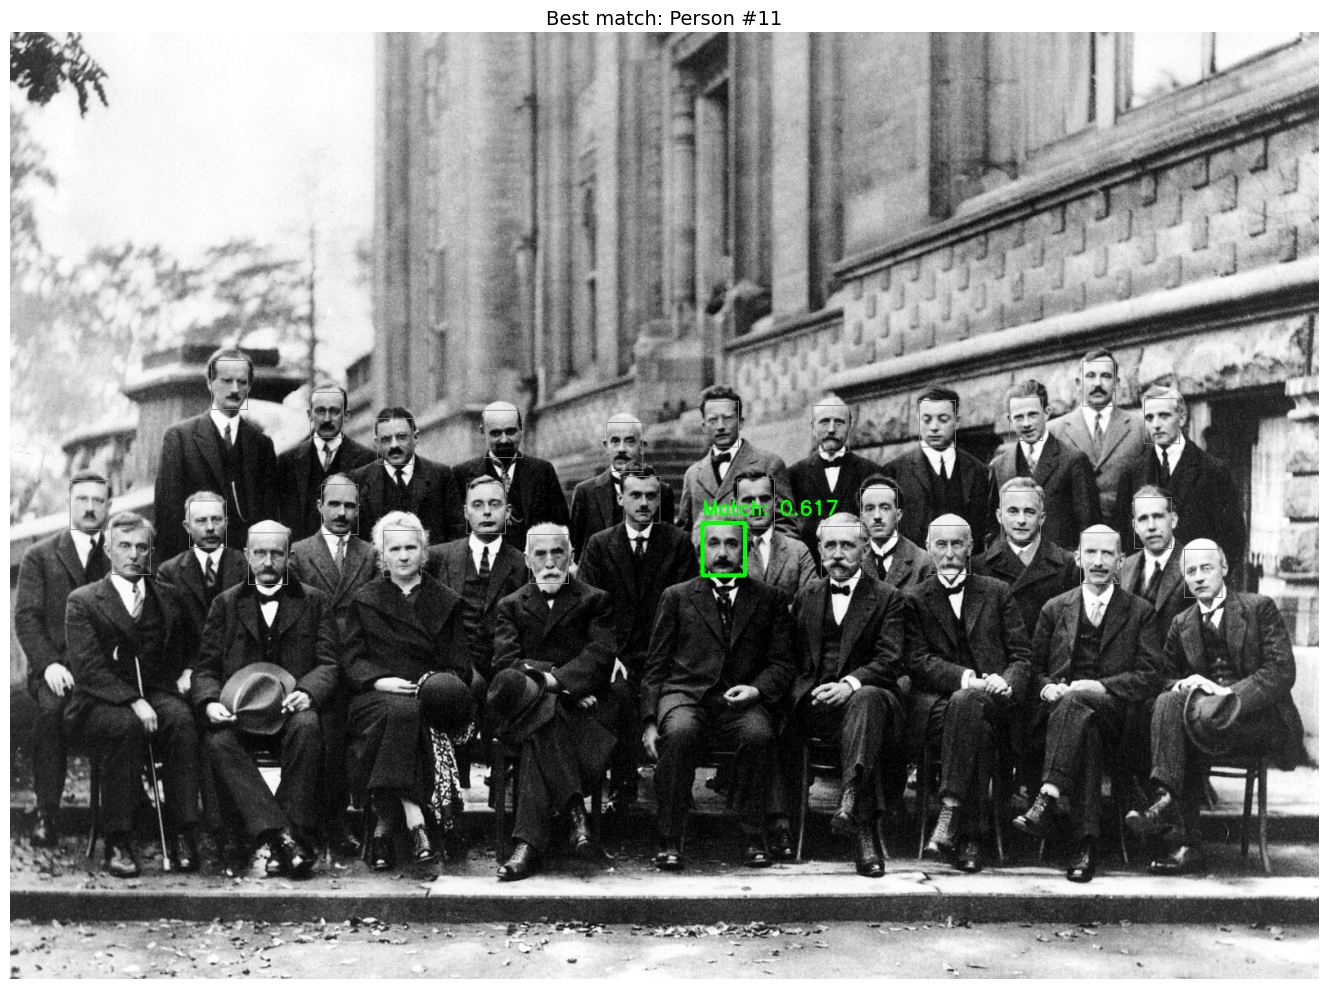

In [8]:
if einstein_faces and group_faces:
    # Get the best match
    best_match_idx, best_similarity = matches[0]

    # Draw bounding boxes
    result_image = group_photo.copy()

    for i, person in enumerate(group_faces):
        bbox = person.bbox.astype(int)

        if i == best_match_idx:
            color = (0, 255, 0)
            thickness = 3
        else:
            color = (128, 128, 128)
            thickness = 1

        cv2.rectangle(result_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)

        if i == best_match_idx:
            label = f'Match: {best_similarity:.3f}'
            cv2.putText(result_image, label, (bbox[0], bbox[1] - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Best match: Person #{best_match_idx + 1}', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


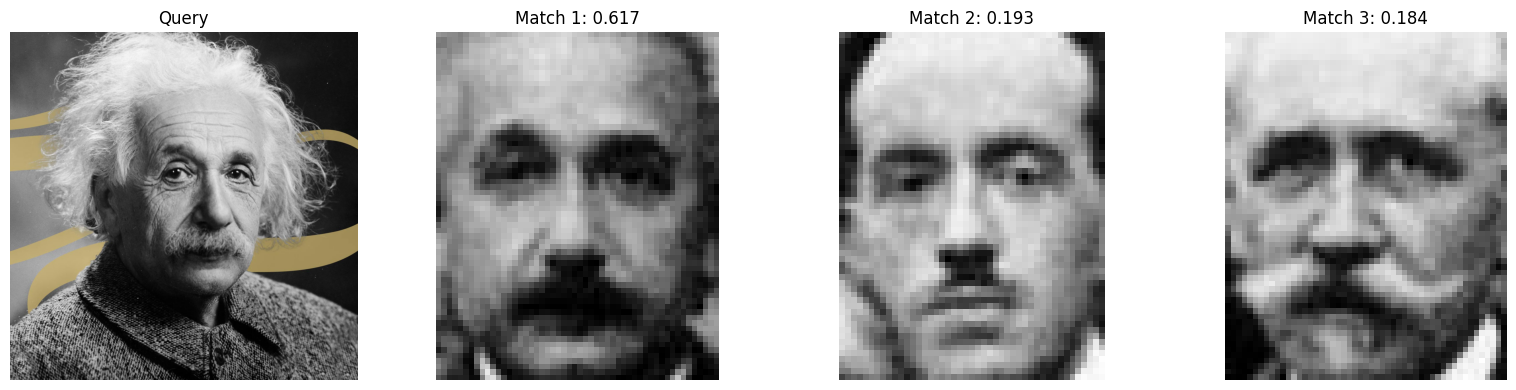

In [9]:
if einstein_faces and group_faces:
    # Show top 3 matches
    top_k = min(3, len(matches))

    fig, axes = plt.subplots(1, top_k + 1, figsize=(16, 4))

    # Show Einstein's face
    einstein_rgb = cv2.cvtColor(einstein_image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(einstein_rgb)
    axes[0].set_title("Query", fontsize=12)
    axes[0].axis('off')

    # Show top 3 matches from the group
    for i, (person_idx, similarity) in enumerate(matches[:top_k]):
        person = group_faces[person_idx]
        bbox = person.bbox.astype(int)

        # Crop this person's face
        face_crop = group_photo[bbox[1]:bbox[3], bbox[0]:bbox[2]]

        if face_crop.size > 0:
            face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
            axes[i + 1].imshow(face_rgb)
            axes[i + 1].set_title(f'Match {i + 1}: {similarity:.3f}', fontsize=12)
            axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


In [10]:
# Use threshold to determine if it's a match
THRESHOLD = 0.6

if einstein_faces and group_faces:
    best_match_idx, best_similarity = matches[0]

    print(f'Best match: Person #{best_match_idx + 1}')
    print(f'Similarity: {best_similarity:.4f}')
    print(f'Threshold: {THRESHOLD}')

    if best_similarity > THRESHOLD:
        print(f'Result: Match found (Einstein is person #{best_match_idx + 1})')
    else:
        print(f'Result: No match (similarity below threshold)')


Best match: Person #11
Similarity: 0.6171
Threshold: 0.6
Result: Match found (Einstein is person #11)


## Notes

- Similarity score ranges from -1 to 1 (higher = more similar)
- Threshold of 0.6 is commonly used (above = match, below = no match)
- Adjust threshold based on your use case (higher = stricter matching)
